> # Barcelona, pisos turísticos.
Queremos sacar los pisos turisticos que tienen licencia  y los que no , pero que están activos en Airbnb, ya que hay algunos pisos que salen en el dataSet pero que están inactivos y son antiguos
Despues sacaremos los hosts que tienen mas de 5 pisos en la plataforma, y los compararemos con el listado oficial de pisos turisticos de Barcelona para identificarlos y ponerlos en la visualizacion de otro color



In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap
import os




In [54]:
print(pd.__version__)

2.0.3


- Usaremos el dataset del Ayuntamiento de Barcelona
https://opendata-ajuntament.barcelona.cat/data/es/dataset/habitatges-us-turistic/resource/b32fa7f6-d464-403b-8a02-0292a64883bf

> # Viviendas de uso turístico de la ciudad de Barcelona. 4 Trimestre año 2024
https://opendata-ajuntament.barcelona.cat/data/es/dataset/habitatges-us-turistic

https://opendata-ajuntament.barcelona.cat/data/dataset/c748799e-1079-44b1-9e60-88d936a3fe70/resource/b32fa7f6-d464-403b-8a02-0292a64883bf/download

Los datos de Airbnb los sacaremos de 
http://insideairbnb.com/barcelona/
11 December, 2022

Para que podamos trabajar con las tablas de Barcelona y Airbn tenemos que cambiar el nombre a alguna columna, como la de Districte, que en airbnb lo llama neighbourhood_group y neighbourhood
asi que  la decision es cual de las dos tablas lo cambiamos,optaremos por cambiarlo en la de airbnb para que se entienda mas que es un distrito y no un barri y asi dejar la de open data barcelona intacta. Posteriormente juntaremos todos los DataSets, pero antes sacaremosl a info de airbnb como -pisos disponibles activos 
- Tipo de licencia y si es una licencia valida o no 
- NUmero de pisos que tiene cada hosts.

para ello sacamos los pisos disponibles
y añadiremos una nueva columna para saber si es legal o ilegal.
Hay dos tipos de ilegalidades:
-el piso que directamente no tiene licencia ni indica que está exento
-el piso/habitacion que indica exento pero realmente no cumple la condidion por ley de que el alquiler sea mas de 30 dias
esta tipologia la indicaremos en una columna nueva


- Limpiaremos la tabla de OPenDataBarcelona quedandonos solo son los datos que vamos a utilizar en la visualizacion
    - Latitud / Longitud 
    - Districte
 
 - La de Airbnb Tb la LImpiaremos
     - neighbourhood
     - host-id
     - latitud - longitud ( nos interesa guardar los dos porque  no todos los pisos están en la base de datos del ayuntamiento y no todos los del ayuntamiento están en la base de datos de airbnb, luego al hacer merge ya veremos con que latitud y longitud nos quedamos.
     
     - minimo de noches 
     
     -last review
     - noches activas por año

In [77]:
airbnb = pd.read_csv("datas/listings.csv", index_col= "id")
airbnb_details = pd.read_csv("datas/listings_detailed.csv", index_col= "id", low_memory=False)
opendata =  pd.read_csv("datas/2024_4T_hut_comunicacio_opendata.csv", low_memory=False)


In [78]:
target_columns = ["listing_url", "description"]
airbnb_merge = pd.merge(airbnb, airbnb_details[target_columns], on='id', how='left')
airbnb_merge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19482 entries, 18674 to 1229629668315924091
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            19482 non-null  object 
 1   host_id                         19482 non-null  int64  
 2   host_name                       19480 non-null  object 
 3   neighbourhood_group             19482 non-null  object 
 4   neighbourhood                   19482 non-null  object 
 5   latitude                        19482 non-null  float64
 6   longitude                       19482 non-null  float64
 7   room_type                       19482 non-null  object 
 8   price                           15422 non-null  float64
 9   minimum_nights                  19482 non-null  int64  
 10  number_of_reviews               19482 non-null  int64  
 11  last_review                     14731 non-null  object 
 12  reviews_per_month  

In [79]:
airbnb_merge['last_review'] = pd.to_datetime(airbnb_merge['last_review'], format='%Y-%m-%d')
airbnb_merge = airbnb_merge[['listing_url','host_id','description','host_name','neighbourhood_group','latitude','longitude','minimum_nights','last_review','calculated_host_listings_count','availability_365', 'license']]
airbnb_merge.rename(columns = {'neighbourhood_group':'DISTRICTE'}, inplace = True)
airbnb_merge.rename(columns = {'license':'NUMERO_REGISTRE_GENERALITAT'}, inplace = True)

airbnb_merge['DISTRICTE'] = airbnb_merge['DISTRICTE'].str.upper()
airbnb_merge.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19482 entries, 18674 to 1229629668315924091
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   listing_url                     19482 non-null  object        
 1   host_id                         19482 non-null  int64         
 2   description                     18665 non-null  object        
 3   host_name                       19480 non-null  object        
 4   DISTRICTE                       19482 non-null  object        
 5   latitude                        19482 non-null  float64       
 6   longitude                       19482 non-null  float64       
 7   minimum_nights                  19482 non-null  int64         
 8   last_review                     14731 non-null  datetime64[ns]
 9   calculated_host_listings_count  19482 non-null  int64         
 10  availability_365                19482 non-null  int64    

In [80]:
opendata.columns


len(opendata)

len(airbnb)


19482

In [81]:
airbnb_merge.head()

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT
id,,,,,,,,,,,,
18674,https://www.airbnb.com/rooms/18674,71615,110m2 apartment to rent in Barcelona. Located ...,Mireia Maria,EIXAMPLE,41.405560,2.17262,1,2024-06-03,28,72,HUTB-002062
23197,https://www.airbnb.com/rooms/23197,90417,"Beautiful spacious apartment, large terrace, 5...",Etain (Marnie),SANT MARTÍ,41.412432,2.21975,3,2024-06-24,1,116,HUTB005057
32711,https://www.airbnb.com/rooms/32711,135703,A lovely two bedroom apartment only 250 m from...,Nick,GRÀCIA,41.405660,2.17015,1,2024-09-05,3,319,HUTB-001722
34241,https://www.airbnb.com/rooms/34241,73163,Located in close proximity to Plaza Real and L...,Andres,CIUTAT VELLA,41.380620,2.17517,5,2024-08-20,3,69,Exempt
34981,https://www.airbnb.com/rooms/34981,73163,Spacious apartment for large families or group...,Andres,CIUTAT VELLA,41.379780,2.17623,5,2024-09-02,3,241,HUTB-150671


In [82]:
airbnb_merge.head()

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT
id,,,,,,,,,,,,
18674,https://www.airbnb.com/rooms/18674,71615,110m2 apartment to rent in Barcelona. Located ...,Mireia Maria,EIXAMPLE,41.405560,2.17262,1,2024-06-03,28,72,HUTB-002062
23197,https://www.airbnb.com/rooms/23197,90417,"Beautiful spacious apartment, large terrace, 5...",Etain (Marnie),SANT MARTÍ,41.412432,2.21975,3,2024-06-24,1,116,HUTB005057
32711,https://www.airbnb.com/rooms/32711,135703,A lovely two bedroom apartment only 250 m from...,Nick,GRÀCIA,41.405660,2.17015,1,2024-09-05,3,319,HUTB-001722
34241,https://www.airbnb.com/rooms/34241,73163,Located in close proximity to Plaza Real and L...,Andres,CIUTAT VELLA,41.380620,2.17517,5,2024-08-20,3,69,Exempt
34981,https://www.airbnb.com/rooms/34981,73163,Spacious apartment for large families or group...,Andres,CIUTAT VELLA,41.379780,2.17623,5,2024-09-02,3,241,HUTB-150671


PREPARACIÓN DE TABLA AIRBNB
- filtramos las columnas QUE  necesitaremos
- cambiamos el nombre de neighbourhood a DISTRICTE
- limpiamos los valores nulos renombrandolos a Nulos y cambiando el tipo de columna a string
- cambiamos el tipo de columna last_review a date

Limpiamos los nulos

In [83]:
airbnb_merge.isnull().sum()

listing_url                          0
host_id                              0
description                        817
host_name                            2
DISTRICTE                            0
latitude                             0
longitude                            0
minimum_nights                       0
last_review                       4751
calculated_host_listings_count       0
availability_365                     0
NUMERO_REGISTRE_GENERALITAT       6194
dtype: int64

Los desactivados los borramos

In [85]:
#pisos activos , esto es super importante para descartar anuncios que no estan activos 
airbnb_merge_clean  =airbnb_merge.loc[  (airbnb_merge['last_review'].notnull()) &  (airbnb_merge['last_review'] > '2023-01-01')&  (airbnb_merge['availability_365'] > 20)]

In [86]:
airbnb_merge_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11590 entries, 18674 to 1227947729562300326
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   listing_url                     11590 non-null  object        
 1   host_id                         11590 non-null  int64         
 2   description                     11208 non-null  object        
 3   host_name                       11590 non-null  object        
 4   DISTRICTE                       11590 non-null  object        
 5   latitude                        11590 non-null  float64       
 6   longitude                       11590 non-null  float64       
 7   minimum_nights                  11590 non-null  int64         
 8   last_review                     11590 non-null  datetime64[ns]
 9   calculated_host_listings_count  11590 non-null  int64         
 10  availability_365                11590 non-null  int64    

In [87]:
len(airbnb_merge_clean)

11590

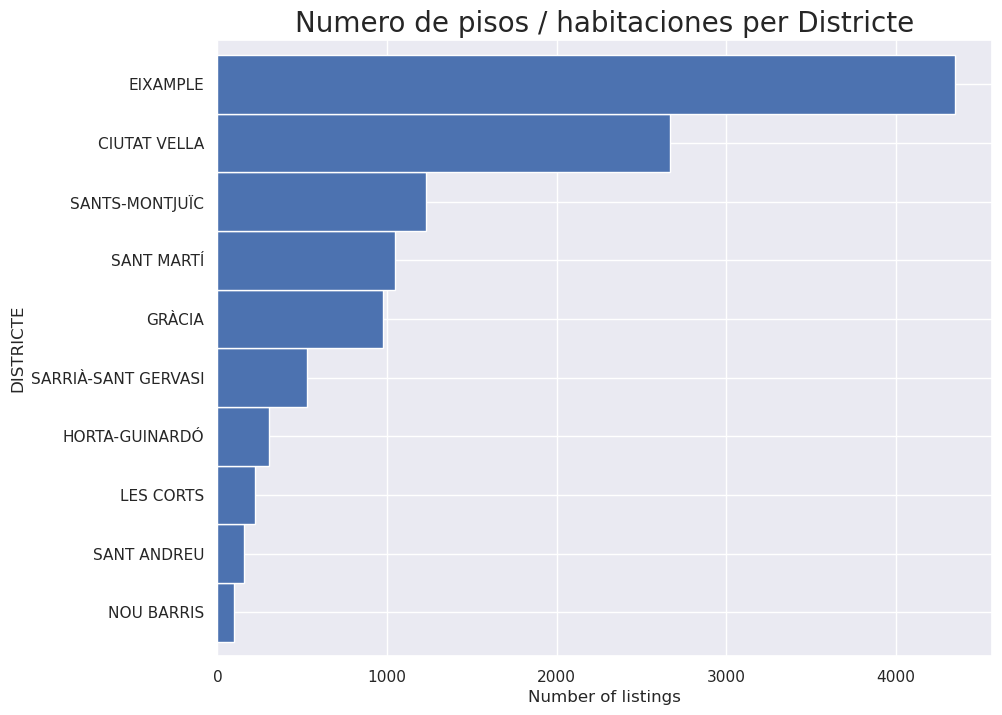

In [88]:
feq=airbnb_merge_clean['DISTRICTE'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Numero de pisos / habitaciones per Districte", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

In [25]:
lats2018 = airbnb_merge_clean['latitude'].tolist()
lons2018 = airbnb_merge_clean['longitude'].tolist()
lons_url = airbnb_merge_clean['listing_url'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[41.38879, 2.15899], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)


m = folium.Map(location=[45.372, -121.6972], zoom_start=12, tiles="Stamen Terrain")
tooltip = "Click me!"
folium.Marker(
    [45.3288, -121.6625], popup="<i>Mt. Hood Meadows</i>", tooltip=tooltip
).add_to(m)
folium.Marker(
    [45.3311, -121.7113], popup="<b>Timberline Lodge</b>", tooltip=tooltip
).add_to(m)

m



map1

We see that neighbourhood_group is useless in Amsterdam, as it contains zero non-null objects. Below, I getting rid of this variable, and am showing the head of the dataframe that I am going to work with.

# 2. Exploración de datos
Tenemos una cantidad de pisos en Airbnb que están activos, son los que tienen mas de 20 dias de disponibilidad al año y que sus ultimos reviews son del año 2022




In [89]:
freq = airbnb_merge_clean.groupby(['host_id']).size().reset_index(name='calculated_host_listings_count')
host_prop = freq.groupby(['calculated_host_listings_count']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

calculated_host_listings_count,1,2,3,4,5,6,7,8,9,10,...,62,69,87,88,121,123,125,150,183,192
count,2513,584,295,141,85,84,43,32,22,21,...,1,1,1,1,1,1,1,1,1,1


vamos a mezclar los datasets que tengan licencia turistica
dataframe avail con bcna .
para eso primero vamos a reemplazar los valores Nan por 0 de la licencia


In [90]:
bcna = airbnb_merge_clean.copy()

Tipo 0 - o indican la licencia y no entran dentro de alquiler por mas de 30 dias > posibles irregularidades en la licencia
Tipo 1 - Con licencia de piso/habitacion turistica

In [91]:
bcna["Tipo"] = bcna[["minimum_nights", "NUMERO_REGISTRE_GENERALITAT"]].apply(
    lambda x: (
        "0" if (x.minimum_nights < 30 and x.NUMERO_REGISTRE_GENERALITAT == 'Nulo') else
        "1" if (x.minimum_nights < 30 and ( x.NUMERO_REGISTRE_GENERALITAT == 'Exempt' or x.NUMERO_REGISTRE_GENERALITAT == 'Nulo' )) else
        "2" if (x.minimum_nights > 29 and ( x.NUMERO_REGISTRE_GENERALITAT == 'Exempt' or x.NUMERO_REGISTRE_GENERALITAT == 'Nulo' ))  else
        "3" if (x.NUMERO_REGISTRE_GENERALITAT != "Nulo" and x.NUMERO_REGISTRE_GENERALITAT != "Exempt") else
        "99"
    ), 
    axis=1
)

bcna["TipoDescripcion"] = bcna[["minimum_nights", "NUMERO_REGISTRE_GENERALITAT"]].apply(
    lambda x: (
        "Nulos-Ilegales" if (x.minimum_nights < 30 and x.NUMERO_REGISTRE_GENERALITAT == 'Nulo') else
        "Exentos ilegales" if (x.minimum_nights < 30 and ( x.NUMERO_REGISTRE_GENERALITAT == 'Exempt' or x.NUMERO_REGISTRE_GENERALITAT == 'Nulo' )) else
        "Exentos" if (x.minimum_nights > 29 and ( x.NUMERO_REGISTRE_GENERALITAT == 'Exempt' or x.NUMERO_REGISTRE_GENERALITAT == 'Nulo' )) else
        "Con Licencia" if (x.NUMERO_REGISTRE_GENERALITAT != "Nulo" and x.NUMERO_REGISTRE_GENERALITAT != "Exempt") else
        "Otro"
    ), 
    axis=1
)


In [92]:
freq = bcna.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,...,62,69,87,88,121,123,125,150,183,192
count,2513,584,295,141,85,84,43,32,22,21,...,1,1,1,1,1,1,1,1,1,1


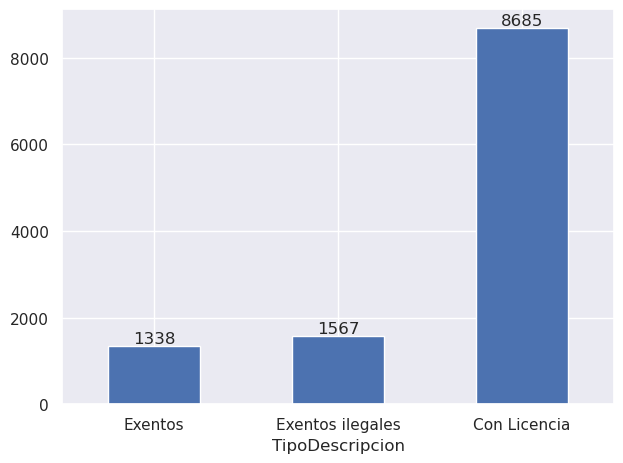

In [93]:
feq=bcna['TipoDescripcion'].value_counts().sort_values(ascending=True)
ax = feq.plot(x='Pillar', y='%', kind='bar', legend=False, rot=0)
ax.bar_label(ax.containers[0], label_type='edge')
plt.tight_layout()

In [94]:
bcna.loc[(bcna["Tipo"] == "1")]


,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT,Tipo,TipoDescripcion
id,,,,,,,,,,,,,,
34241,https://www.airbnb.com/rooms/34241,73163,Located in close proximity to Plaza Real and L...,Andres,CIUTAT VELLA,41.380620,2.175170,5,2024-08-20,3,69,Exempt,1,Exentos ilegales
267816,https://www.airbnb.com/rooms/267816,1404293,The yacht is moored at Port Forum Marina since...,Sergio,CIUTAT VELLA,41.377810,2.184450,2,2023-10-25,1,360,Exempt,1,Exentos ilegales
621656,https://www.airbnb.com/rooms/621656,3081150,If you are quiet and respectful people looking...,Andrea,SANTS-MONTJUÏC,41.372060,2.141170,1,2024-09-05,2,93,Exempt,1,Exentos ilegales
866483,https://www.airbnb.com/rooms/866483,4427588,Wonderful guest suite with 30 square meters of...,Gado,GRÀCIA,41.399860,2.163770,3,2024-08-21,1,321,Exempt,1,Exentos ilegales
1630947,https://www.airbnb.com/rooms/1630947,8666718,NaN,Ana,GRÀCIA,41.397380,2.159080,2,2024-08-18,1,129,Exempt,1,Exentos ilegales
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215924933025866078,https://www.airbnb.com/rooms/1215924933025866078,568847772,Located in the ancient and central proletarian...,Ross,CIUTAT VELLA,41.379670,2.165661,1,2024-08-15,4,55,Exempt,1,Exentos ilegales
1216676090897499356,https://www.airbnb.com/rooms/1216676090897499356,568847772,Cozy room in the ancient and central proletari...,Ross,CIUTAT VELLA,41.378308,2.164298,1,2024-08-23,4,58,Exempt,1,Exentos ilegales
1217165492252195603,https://www.airbnb.com/rooms/1217165492252195603,333769431,Base this home and you'll be a step away from ...,Mauricio,CIUTAT VELLA,41.383684,2.168341,1,2024-08-09,16,356,Exempt,1,Exentos ilegales


In [101]:

districtes_barris =  pd.read_csv("datas/districtes_i_barris_170705.csv")
districtes_barris['NOM_DISTRICTE'] = districtes_barris['NOM_DISTRICTE'].str.upper()



In [104]:
districtes = districtes_barris.groupby(['NOM_DISTRICTE']).mean(numeric_only=True).reset_index()districtes = districtes.reset_index(level=0)


In [105]:
districtes = districtes.reset_index(level=0)

In [106]:
districtes = districtes.drop('CODI_BARRI', axis=1)


In [107]:
districtes['CODI_DISTRICTE'] = districtes['CODI_DISTRICTE'].astype(int)
# Sorting by column 'Country'
districtes.sort_values(by=['CODI_DISTRICTE'])

,index,NOM_DISTRICTE,CODI_DISTRICTE
0,0,CIUTAT VELLA,1
1,1,EIXAMPLE,2
8,8,SANTS-MONTJUÏC,3
4,4,LES CORTS,4
9,9,SARRIÀ-SANT GERVASI,5
2,2,GRÀCIA,6
3,3,HORTA-GUINARDÓ,7
5,5,NOU BARRIS,8
6,6,SANT ANDREU,9
7,7,SANT MARTÍ,10


In [34]:
districtes['CODI_DISTRICTE'] = districtes['CODI_DISTRICTE'].astype(int)
# Sorting by column 'Country'
districtes.sort_values(by=['CODI_DISTRICTE'])


,NOM_DISTRICTE,CODI_DISTRICTE
0,CIUTAT VELLA,1
1,EIXAMPLE,2
8,SANTS-MONTJUÏC,3
4,LES CORTS,4
9,SARRIÀ-SANT GERVASI,5
2,GRÀCIA,6
3,HORTA-GUINARDÓ,7
5,NOU BARRIS,8
6,SANT ANDREU,9
7,SANT MARTÍ,10


In [108]:
districtes.rename(columns={"NOM_DISTRICTE": "DISTRICTE"}, inplace=True)
districtes.head()

,index,DISTRICTE,CODI_DISTRICTE
0,0,CIUTAT VELLA,1
1,1,EIXAMPLE,2
2,2,GRÀCIA,6
3,3,HORTA-GUINARDÓ,7
4,4,LES CORTS,4


In [109]:
districtes

,index,DISTRICTE,CODI_DISTRICTE
0,0,CIUTAT VELLA,1
1,1,EIXAMPLE,2
2,2,GRÀCIA,6
3,3,HORTA-GUINARDÓ,7
4,4,LES CORTS,4
5,5,NOU BARRIS,8
6,6,SANT ANDREU,9
7,7,SANT MARTÍ,10
8,8,SANTS-MONTJUÏC,3
9,9,SARRIÀ-SANT GERVASI,5


In [110]:
bcna_clean_location = pd.merge(bcna, districtes, on='DISTRICTE', how='left')

In [111]:
bcna_clean_location.head()

,listing_url,host_id,description,host_name,DISTRICTE,latitude,longitude,minimum_nights,last_review,calculated_host_listings_count,availability_365,NUMERO_REGISTRE_GENERALITAT,Tipo,TipoDescripcion,index,CODI_DISTRICTE
0,https://www.airbnb.com/rooms/18674,71615,110m2 apartment to rent in Barcelona. Located ...,Mireia Maria,EIXAMPLE,41.405560,2.17262,1,2024-06-03,28,72,HUTB-002062,3,Con Licencia,1,2
1,https://www.airbnb.com/rooms/23197,90417,"Beautiful spacious apartment, large terrace, 5...",Etain (Marnie),SANT MARTÍ,41.412432,2.21975,3,2024-06-24,1,116,HUTB005057,3,Con Licencia,7,10
2,https://www.airbnb.com/rooms/32711,135703,A lovely two bedroom apartment only 250 m from...,Nick,GRÀCIA,41.405660,2.17015,1,2024-09-05,3,319,HUTB-001722,3,Con Licencia,2,6
3,https://www.airbnb.com/rooms/34241,73163,Located in close proximity to Plaza Real and L...,Andres,CIUTAT VELLA,41.380620,2.17517,5,2024-08-20,3,69,Exempt,1,Exentos ilegales,0,1
4,https://www.airbnb.com/rooms/34981,73163,Spacious apartment for large families or group...,Andres,CIUTAT VELLA,41.379780,2.17623,5,2024-09-02,3,241,HUTB-150671,3,Con Licencia,0,1


In [112]:
filepath2 = ('datas/out/bcna_clean_location_2024.csv')
districtes_file =  ('datas/out/districtes.csv')
bcna_clean_location.to_csv(filepath2) 
districtes.to_csv(districtes_file) 

In [113]:
exentos =bcna_clean_location.loc[(bcna_clean_location["Tipo"] == "1")]

In [114]:
example = exentos.loc[(exentos["DISTRICTE"] == "EIXAMPLE")]
len(example)

376

In [115]:
bcna_clean_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11590 entries, 0 to 11589
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   listing_url                     11590 non-null  object        
 1   host_id                         11590 non-null  int64         
 2   description                     11208 non-null  object        
 3   host_name                       11590 non-null  object        
 4   DISTRICTE                       11590 non-null  object        
 5   latitude                        11590 non-null  float64       
 6   longitude                       11590 non-null  float64       
 7   minimum_nights                  11590 non-null  int64         
 8   last_review                     11590 non-null  datetime64[ns]
 9   calculated_host_listings_count  11590 non-null  int64         
 10  availability_365                11590 non-null  int64         
 11  NU

In [116]:
exentos_legales =bcna_clean_location.loc[(bcna_clean_location["Tipo"] == "3") ]
exentos_legales.head()
len(exentos_legales)

8685

In [117]:
len(exentos_legales)

8685

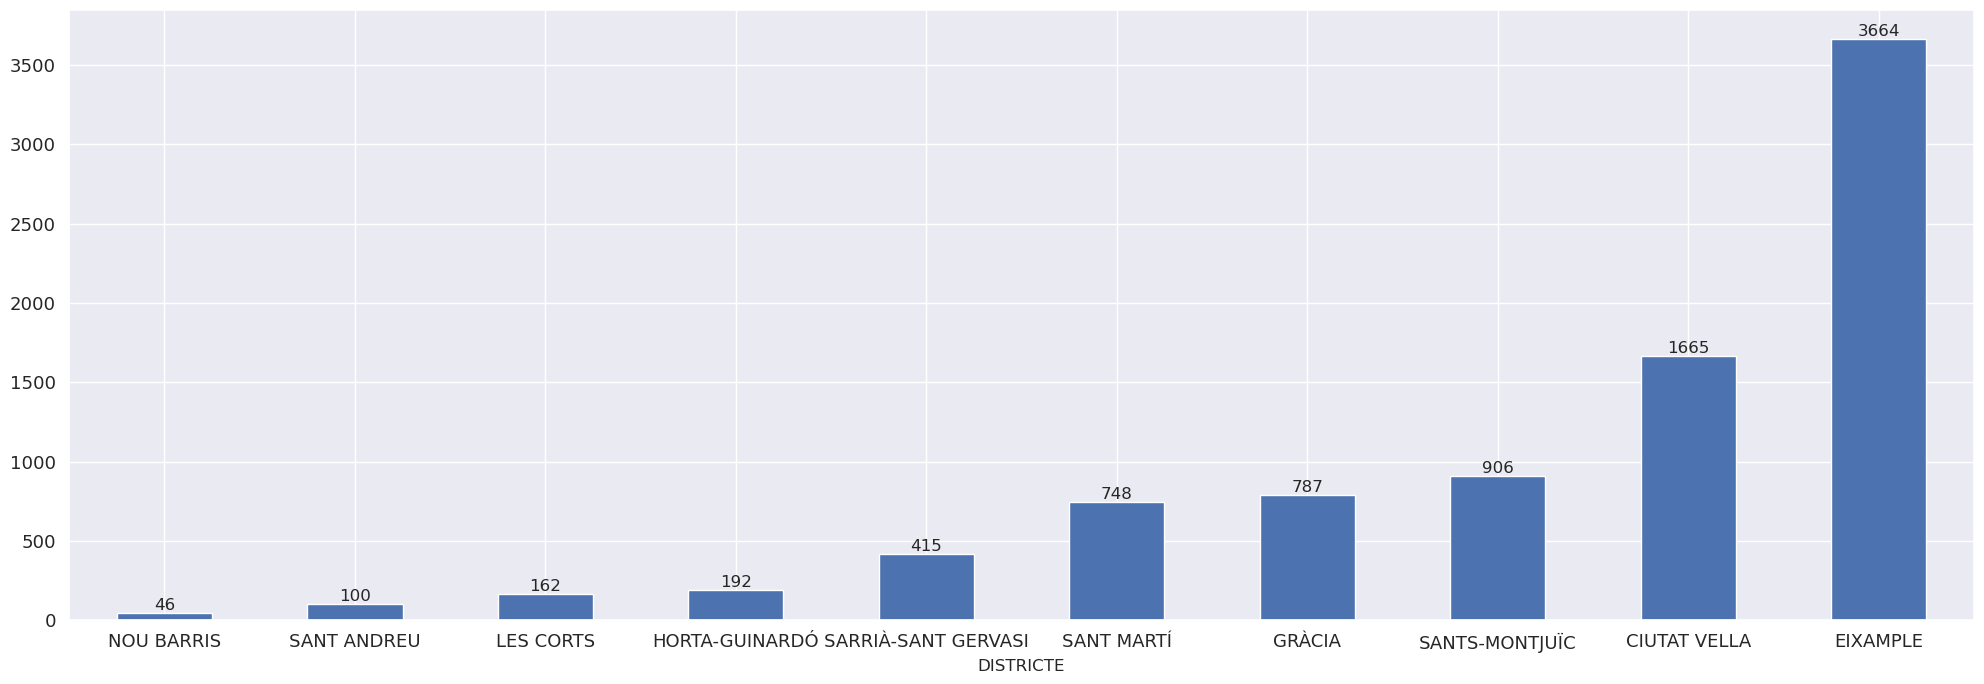

In [118]:
por_districtes_exentos=exentos_legales['DISTRICTE'].value_counts().sort_values(ascending=True)
ax = por_districtes_exentos.plot(x='Pillar', y='%', kind='bar', legend=False, rot=0, figsize=(20,7), fontsize=13)
ax.bar_label(ax.containers[0], label_type='edge')
plt.tight_layout()

In [119]:
lats2018 = airbnb_merge_clean['latitude'].tolist()
lons2018 = airbnb_merge_clean['longitude'].tolist()
lons_url = airbnb_merge_clean['listing_url'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[41.38879, 2.15899], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)


m = folium.Map(location=[45.372, -121.6972], zoom_start=12, tiles="Stamen Terrain")
tooltip = "Click me!"
folium.Marker(
    [45.3288, -121.6625], popup="<i>Mt. Hood Meadows</i>", tooltip=tooltip
).add_to(m)
folium.Marker(
    [45.3311, -121.7113], popup="<b>Timberline Lodge</b>", tooltip=tooltip
).add_to(m)

m